In [2]:
from keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2DTranspose, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils.generic_utils import Progbar
import numpy as np
import pandas as pd
import os
from keras.layers.advanced_activations import LeakyReLU
import matplotlib.pyplot as plt
%matplotlib inline

#### Se carga el MNIST con el que se va a probar la arquitectura.

In [3]:
data_train = pd.read_csv("./data/train.csv")
data_test = pd.read_csv("./data/test.csv")
data_train.shape, data_test.shape

((42000, 785), (28000, 784))

In [4]:
data_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


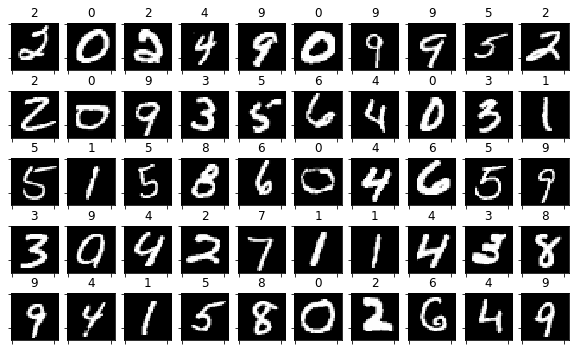

In [5]:
num_imgs = 50 #mostrar 25 imágenes aleatorias
fig = plt.figure(figsize=(10,6))
for i in range(num_imgs):
    ax=fig.add_subplot(5,10,i+1)
    rdm_img = np.random.randint(1,data_train.shape[0]-1)
    plt.imshow(np.array(data_train.iloc[rdm_img,1:]).reshape(28,28), cmap = plt.cm.Greys_r)
    ax.set_title(int(data_train.iloc[rdm_img,0]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

In [6]:
import os
import numpy as np
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

class GANs:
    #inicialización de variables
    def __init__(self, width=28, height=28, channels=1):
        self.WIDTH = width
        self.HEIGHT = height
        self.CHANNELS = channels
        self.SHAPE = (width, height, channels)
        self.optimizer = Adam(lr=0.0002, beta_1=0.5, decay=8e-8)
        self.G = self.noise_generator()
        self.G.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        self.D = self.discriminator()
        self.D.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])
        self.stacked_generator_discriminator = self.__stacked_generator_discriminator()
        self.stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        
    #Para unir el generador y el disctiminador
    def __stacked_generator_discriminator(self):

        self.D.trainable = False
        model = Sequential()
        model.add(self.G)
        model.add(self.D)
        return model
    
    #generador de ruido
    def noise_generator(self):
        model = Sequential()
        model.add(Dense(256, input_shape=(100,)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.1))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(Dropout(0.1))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(self.WIDTH  * self.HEIGHT * self.CHANNELS, activation='tanh'))
        model.add(Reshape((self.WIDTH, self.HEIGHT, self.CHANNELS)))
        return model

    #Discriminador del modelo
    def discriminator(self):    
        model = Sequential()
        model.add(Flatten(input_shape=self.SHAPE))
        model.add(Dense((self.WIDTH * self.HEIGHT * self.CHANNELS), input_shape=self.SHAPE))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(np.int64((self.WIDTH * self.HEIGHT * self.CHANNELS)/2)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.1))
        model.add(Dense(1, activation='sigmoid'))
        #model.summary()
        return model
    
    #Entrenar la GANs
    def train(self, X_train, epochs=1000, batch=64):
        ## train discriminator
        for cnt in range(epochs):
            random_index = np.random.randint(0, len(X_train) - np.int64(batch/2))
            legit_images = X_train[random_index:random_index + np.int64(batch/2)].reshape(np.int64(batch/2),
                                                                                            self.WIDTH,
                                                                                            self.HEIGHT,
                                                                                            self.CHANNELS)
            gen_noise = np.random.normal(0, 1, (np.int64(batch/2), 100))
            syntetic_images = self.G.predict(gen_noise)
            
            #print(legit_images.shape, syntetic_images.shape)
            
            x_combined_batch = np.concatenate((legit_images, syntetic_images))
            y_combined_batch = np.concatenate((np.ones((np.int64(batch/2), 1)), np.zeros((np.int64(batch/2), 1))))

            d_loss = self.D.train_on_batch(x_combined_batch, y_combined_batch)


            # train generator
            noise = np.random.normal(0, 1, (batch, 100))
            y_mislabled = np.ones((batch, 1))

            g_loss = self.stacked_generator_discriminator.train_on_batch(noise, y_mislabled)

            print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0],
                                                                                           g_loss))
            bined_batch = np.concatenate((np.ones((np.int64(batch/2), 1)), np.zeros((np.int64(batch/2), 1))))
            if (cnt % 100) ==0: #dibujar unos pocos
                self.plot_images(save2file=True, step=cnt)
            
    def plot_images(self, save2file=False, samples=16, step=0):
        # Para pintar o guardar las imágenes
        if not os.path.exists("./images"):
            os.makedirs("./images")
        filename = "./images/mnist_" + str(step) + ".png"
        noise = np.random.normal(0, 1, (samples, 100))

        images = self.G.predict(noise)
        #print(images.shape)
        plt.figure(figsize=(10, 10))

        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.HEIGHT, self.WIDTH])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()

        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()

In [7]:
data_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
X_train = np.array(data_train.iloc[:,1:])
y_train = np.array(data_train.iloc[:,0])

In [9]:
m = 255/2
X_train = (X_train.astype(np.float32) - m) / m
X_train = np.expand_dims(X_train, axis=3)

/home/ejrueda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
#np.expand_dims - Para expandir las dimensiones de un array

In [11]:
gan = GANs()
gan.train(X_train)

/home/ejrueda/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0, [Discriminator :: d_loss: 0.936967], [ Generator :: loss: 0.575395]
epoch: 1, [Discriminator :: d_loss: 0.537359], [ Generator :: loss: 0.638129]
epoch: 2, [Discriminator :: d_loss: 0.425663], [ Generator :: loss: 0.755591]
epoch: 3, [Discriminator :: d_loss: 0.363941], [ Generator :: loss: 0.993120]
epoch: 4, [Discriminator :: d_loss: 0.275274], [ Generator :: loss: 1.156156]
epoch: 5, [Discriminator :: d_loss: 0.231502], [ Generator :: loss: 1.406512]
epoch: 6, [Discriminator :: d_loss: 0.172617], [ Generator :: loss: 1.650784]
epoch: 7, [Discriminator :: d_loss: 0.158112], [ Generator :: loss: 1.909637]
epoch: 8, [Discriminator :: d_loss: 0.115545], [ Generator :: loss: 2.040600]
epoch: 9, [Discriminator :: d_loss: 0.103502], [ Generator :: loss: 2.204143]
epoch: 10, [Discriminator :: d_loss: 0.079422], [ Generator :: loss: 2.329319]
epoch: 11, [Discriminator :: d_loss: 0.082858], [ Generator :: loss: 2.456227]
epoch: 12, [Discriminator :: d_loss: 0.071035], [ Generator ::

epoch: 104, [Discriminator :: d_loss: 0.030689], [ Generator :: loss: 6.372479]
epoch: 105, [Discriminator :: d_loss: 0.068439], [ Generator :: loss: 5.239347]
epoch: 106, [Discriminator :: d_loss: 0.146942], [ Generator :: loss: 5.569475]
epoch: 107, [Discriminator :: d_loss: 0.044035], [ Generator :: loss: 6.482362]
epoch: 108, [Discriminator :: d_loss: 0.044352], [ Generator :: loss: 6.606770]
epoch: 109, [Discriminator :: d_loss: 0.031140], [ Generator :: loss: 6.059645]
epoch: 110, [Discriminator :: d_loss: 0.031041], [ Generator :: loss: 5.910358]
epoch: 111, [Discriminator :: d_loss: 0.033251], [ Generator :: loss: 6.221609]
epoch: 112, [Discriminator :: d_loss: 0.037766], [ Generator :: loss: 6.033054]
epoch: 113, [Discriminator :: d_loss: 0.033109], [ Generator :: loss: 6.060255]
epoch: 114, [Discriminator :: d_loss: 0.040709], [ Generator :: loss: 6.116489]
epoch: 115, [Discriminator :: d_loss: 0.034340], [ Generator :: loss: 6.192743]
epoch: 116, [Discriminator :: d_loss: 0.

epoch: 211, [Discriminator :: d_loss: 0.245132], [ Generator :: loss: 3.450086]
epoch: 212, [Discriminator :: d_loss: 0.343142], [ Generator :: loss: 1.777221]
epoch: 213, [Discriminator :: d_loss: 0.524258], [ Generator :: loss: 3.374400]
epoch: 214, [Discriminator :: d_loss: 0.402158], [ Generator :: loss: 2.625350]
epoch: 215, [Discriminator :: d_loss: 0.341043], [ Generator :: loss: 3.854101]
epoch: 216, [Discriminator :: d_loss: 0.502148], [ Generator :: loss: 1.247348]
epoch: 217, [Discriminator :: d_loss: 0.742093], [ Generator :: loss: 2.312763]
epoch: 218, [Discriminator :: d_loss: 0.242186], [ Generator :: loss: 4.146663]
epoch: 219, [Discriminator :: d_loss: 0.385873], [ Generator :: loss: 1.343267]
epoch: 220, [Discriminator :: d_loss: 0.652055], [ Generator :: loss: 2.264246]
epoch: 221, [Discriminator :: d_loss: 0.297620], [ Generator :: loss: 4.652358]
epoch: 222, [Discriminator :: d_loss: 0.723437], [ Generator :: loss: 0.978427]
epoch: 223, [Discriminator :: d_loss: 0.

epoch: 316, [Discriminator :: d_loss: 0.663502], [ Generator :: loss: 0.582682]
epoch: 317, [Discriminator :: d_loss: 0.649597], [ Generator :: loss: 0.947114]
epoch: 318, [Discriminator :: d_loss: 0.643304], [ Generator :: loss: 0.708827]
epoch: 319, [Discriminator :: d_loss: 0.610034], [ Generator :: loss: 0.832113]
epoch: 320, [Discriminator :: d_loss: 0.614158], [ Generator :: loss: 0.781522]
epoch: 321, [Discriminator :: d_loss: 0.606329], [ Generator :: loss: 0.844147]
epoch: 322, [Discriminator :: d_loss: 0.607298], [ Generator :: loss: 0.960350]
epoch: 323, [Discriminator :: d_loss: 0.645201], [ Generator :: loss: 0.587404]
epoch: 324, [Discriminator :: d_loss: 0.652700], [ Generator :: loss: 0.963626]
epoch: 325, [Discriminator :: d_loss: 0.632572], [ Generator :: loss: 0.696999]
epoch: 326, [Discriminator :: d_loss: 0.623079], [ Generator :: loss: 0.782538]
epoch: 327, [Discriminator :: d_loss: 0.603185], [ Generator :: loss: 0.774557]
epoch: 328, [Discriminator :: d_loss: 0.

epoch: 421, [Discriminator :: d_loss: 0.568479], [ Generator :: loss: 0.921204]
epoch: 422, [Discriminator :: d_loss: 0.591199], [ Generator :: loss: 0.852829]
epoch: 423, [Discriminator :: d_loss: 0.608673], [ Generator :: loss: 0.790023]
epoch: 424, [Discriminator :: d_loss: 0.570830], [ Generator :: loss: 0.875341]
epoch: 425, [Discriminator :: d_loss: 0.572768], [ Generator :: loss: 0.738599]
epoch: 426, [Discriminator :: d_loss: 0.596737], [ Generator :: loss: 0.896432]
epoch: 427, [Discriminator :: d_loss: 0.630026], [ Generator :: loss: 0.670419]
epoch: 428, [Discriminator :: d_loss: 0.612114], [ Generator :: loss: 0.932337]
epoch: 429, [Discriminator :: d_loss: 0.583033], [ Generator :: loss: 0.849643]
epoch: 430, [Discriminator :: d_loss: 0.600901], [ Generator :: loss: 0.849790]
epoch: 431, [Discriminator :: d_loss: 0.596097], [ Generator :: loss: 0.763242]
epoch: 432, [Discriminator :: d_loss: 0.568947], [ Generator :: loss: 1.012686]
epoch: 433, [Discriminator :: d_loss: 0.

epoch: 526, [Discriminator :: d_loss: 0.646874], [ Generator :: loss: 0.734463]
epoch: 527, [Discriminator :: d_loss: 0.584100], [ Generator :: loss: 0.941350]
epoch: 528, [Discriminator :: d_loss: 0.618745], [ Generator :: loss: 1.052911]
epoch: 529, [Discriminator :: d_loss: 0.591934], [ Generator :: loss: 0.697006]
epoch: 530, [Discriminator :: d_loss: 0.631537], [ Generator :: loss: 0.955702]
epoch: 531, [Discriminator :: d_loss: 0.563597], [ Generator :: loss: 1.005846]
epoch: 532, [Discriminator :: d_loss: 0.560071], [ Generator :: loss: 0.780332]
epoch: 533, [Discriminator :: d_loss: 0.611188], [ Generator :: loss: 0.861121]
epoch: 534, [Discriminator :: d_loss: 0.589614], [ Generator :: loss: 1.244598]
epoch: 535, [Discriminator :: d_loss: 0.637627], [ Generator :: loss: 0.470227]
epoch: 536, [Discriminator :: d_loss: 0.693519], [ Generator :: loss: 1.463905]
epoch: 537, [Discriminator :: d_loss: 0.636216], [ Generator :: loss: 0.583211]
epoch: 538, [Discriminator :: d_loss: 0.

epoch: 631, [Discriminator :: d_loss: 0.565805], [ Generator :: loss: 0.900198]
epoch: 632, [Discriminator :: d_loss: 0.603306], [ Generator :: loss: 0.942517]
epoch: 633, [Discriminator :: d_loss: 0.619757], [ Generator :: loss: 0.845590]
epoch: 634, [Discriminator :: d_loss: 0.583922], [ Generator :: loss: 0.903698]
epoch: 635, [Discriminator :: d_loss: 0.563739], [ Generator :: loss: 0.731558]
epoch: 636, [Discriminator :: d_loss: 0.576348], [ Generator :: loss: 1.208351]
epoch: 637, [Discriminator :: d_loss: 0.614230], [ Generator :: loss: 0.548342]
epoch: 638, [Discriminator :: d_loss: 0.620263], [ Generator :: loss: 1.213406]
epoch: 639, [Discriminator :: d_loss: 0.660510], [ Generator :: loss: 0.691035]
epoch: 640, [Discriminator :: d_loss: 0.610112], [ Generator :: loss: 1.078301]
epoch: 641, [Discriminator :: d_loss: 0.643639], [ Generator :: loss: 0.692682]
epoch: 642, [Discriminator :: d_loss: 0.599378], [ Generator :: loss: 1.086937]
epoch: 643, [Discriminator :: d_loss: 0.

epoch: 736, [Discriminator :: d_loss: 0.618417], [ Generator :: loss: 0.675658]
epoch: 737, [Discriminator :: d_loss: 0.631944], [ Generator :: loss: 0.998824]
epoch: 738, [Discriminator :: d_loss: 0.590313], [ Generator :: loss: 0.718258]
epoch: 739, [Discriminator :: d_loss: 0.551959], [ Generator :: loss: 1.013665]
epoch: 740, [Discriminator :: d_loss: 0.650010], [ Generator :: loss: 0.693810]
epoch: 741, [Discriminator :: d_loss: 0.634112], [ Generator :: loss: 0.931181]
epoch: 742, [Discriminator :: d_loss: 0.556571], [ Generator :: loss: 0.925998]
epoch: 743, [Discriminator :: d_loss: 0.571205], [ Generator :: loss: 0.725890]
epoch: 744, [Discriminator :: d_loss: 0.605658], [ Generator :: loss: 1.006973]
epoch: 745, [Discriminator :: d_loss: 0.600731], [ Generator :: loss: 0.697850]
epoch: 746, [Discriminator :: d_loss: 0.579286], [ Generator :: loss: 0.903205]
epoch: 747, [Discriminator :: d_loss: 0.574591], [ Generator :: loss: 1.036847]
epoch: 748, [Discriminator :: d_loss: 0.

epoch: 843, [Discriminator :: d_loss: 0.553783], [ Generator :: loss: 0.725509]
epoch: 844, [Discriminator :: d_loss: 0.554881], [ Generator :: loss: 1.395625]
epoch: 845, [Discriminator :: d_loss: 0.572155], [ Generator :: loss: 0.699310]
epoch: 846, [Discriminator :: d_loss: 0.556208], [ Generator :: loss: 1.343208]
epoch: 847, [Discriminator :: d_loss: 0.591238], [ Generator :: loss: 0.812247]
epoch: 848, [Discriminator :: d_loss: 0.560631], [ Generator :: loss: 1.165914]
epoch: 849, [Discriminator :: d_loss: 0.575114], [ Generator :: loss: 0.677748]
epoch: 850, [Discriminator :: d_loss: 0.582583], [ Generator :: loss: 0.991459]
epoch: 851, [Discriminator :: d_loss: 0.561150], [ Generator :: loss: 0.966066]
epoch: 852, [Discriminator :: d_loss: 0.482599], [ Generator :: loss: 0.834334]
epoch: 853, [Discriminator :: d_loss: 0.576106], [ Generator :: loss: 1.095340]
epoch: 854, [Discriminator :: d_loss: 0.540730], [ Generator :: loss: 0.980065]
epoch: 855, [Discriminator :: d_loss: 0.

epoch: 948, [Discriminator :: d_loss: 0.586246], [ Generator :: loss: 0.925876]
epoch: 949, [Discriminator :: d_loss: 0.531935], [ Generator :: loss: 0.756817]
epoch: 950, [Discriminator :: d_loss: 0.562970], [ Generator :: loss: 1.224551]
epoch: 951, [Discriminator :: d_loss: 0.658361], [ Generator :: loss: 0.699805]
epoch: 952, [Discriminator :: d_loss: 0.632849], [ Generator :: loss: 0.975378]
epoch: 953, [Discriminator :: d_loss: 0.535369], [ Generator :: loss: 0.983558]
epoch: 954, [Discriminator :: d_loss: 0.557273], [ Generator :: loss: 0.953345]
epoch: 955, [Discriminator :: d_loss: 0.580531], [ Generator :: loss: 0.974445]
epoch: 956, [Discriminator :: d_loss: 0.588605], [ Generator :: loss: 0.767785]
epoch: 957, [Discriminator :: d_loss: 0.558844], [ Generator :: loss: 1.453033]
epoch: 958, [Discriminator :: d_loss: 0.658254], [ Generator :: loss: 0.396072]
epoch: 959, [Discriminator :: d_loss: 0.725277], [ Generator :: loss: 1.688695]
epoch: 960, [Discriminator :: d_loss: 0.